# Look into worst traces

In [1]:
import pickle
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal']
       #'Netherlands']

traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None:
        print(" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace = trace.sel(chain=np.where(~mask)[0])
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Italy
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for Belgium
Use 4000 sample runs for France
Use 4000 sample runs for Portugal


## Compute rhat

In [116]:
from multiprocessing import Pool
import arviz as az

def get_max_rhat(country, trace):
    return az.rhat(trace)
    
rhats = []
    
with Pool(processes=6) as pool:
    results = []
    for i, country in enumerate(countries):
        trace = traces[i]    
        result = pool.apply_async(get_max_rhat, (country, trace)) 
        results.append(result)
    for res in results:
        rhats.append(res.get())


/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/data.nst/smohr/

In [193]:
worst_params = []

for rhat in rhats:
    vars = []
    for x in rhat.max():
        vars.append(x)
    vars

    worst = np.argmax(rhats[0].max().to_array().values)
    worst_params.append(vars[worst])



In [194]:
worst_params

['fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday',
 'fraction_delayed_by_weekday']

In [197]:
worst_dim_frac_delays = []
for rhat in rhats:
    w = np.argmax(rhat["fraction_delayed_by_weekday"].values)
    worst_dim_frac_delays.append(w)

## Compute between trace variance to use in plots

In [206]:
from multiprocessing import Pool
from itertools import combinations

combs = combinations([0,1,2,3,4,5,6,7],2)
combs = sorted(set(combs))

def compute_worst_chain_combs(country,trace, worst_dim_frac_delay):
    # Compute variance [:,:,worst_dim_frac_delay]
    # Get all combinations
    combs = combinations(trace.posterior.chain.values,2)
    combs = sorted(set(combs))
    
    v = []
    for [c1,c2] in combs:
        var_both = trace.posterior["fraction_delayed_by_weekday"].sel(chain=[c1,c2]).var()
        var_c1 = trace.posterior["fraction_delayed_by_weekday"].sel(chain=[c1]).var()
        var_c2 = trace.posterior["fraction_delayed_by_weekday"].sel(chain=[c2]).var()
        v.append(np.max(var_both/(var_c1+var_c2)*2))
    v = np.array(v)
    return v, list(combs[np.argmax(v)])

chain_variances = []
worst_chains = []
with Pool(processes=6) as pool:
    results = []
    for i, country in enumerate(countries):
        trace = traces[i]    
        result = pool.apply_async(compute_worst_chain_combs, (country, trace, worst_dim_frac_delays[i])) 
        results.append(result)
    for res in results:
        [c,w] = res.get()
        chain_variances.append(c)
        worst_chains.append(w)

## Plot selected variables from trace

- Worst fraction delayed by weekday
- Participation fraction
- Percentage soccer cases

In [209]:
import calendar
import matplotlib.ticker as mtick
from covid19_soccer.plot.other import calc_fraction_primary

def plot_trace(var, trace, ax, index=0, samples=None, highlight_chains=None):
    """ Utils function to plot a trace (chains and samples)
    Parameters
    ----------
    var: sring
        Variable name in trace
    trace: arviz.InferenceData
        Trace
    ax: mpl.axes
        Matplotlib axes
    samples: np array
        If given ignores the var and trace!
    highlight_chains: tuple
        Specific chains to highlight
    """
    if samples is None:
        samples = trace.posterior[var] # dims: chain, samples, ...
    
    colors_chain = cmap = mpl.cm.get_cmap('tab10')
    
    # Iterate all chains
    i = 0
    for c in range(samples.shape[0]):
        
        kwargs = {
            "color":colors_chain(c/10),
            "lw":0.5,
            "label":f"Chain {c+1}"
        }
        if highlight_chains is not None:
            if c in highlight_chains:
                kwargs["color"] = colors_chain(i/10)
                kwargs["zorder"] = 100
                i = i+1
            else:
                kwargs["color"] = "silver"
        if index is None:
            ax.plot(samples[c,:],**kwargs)
        elif np.array(index).ndim == 1:
            ax.plot(samples[c,:,index[0],index[1]],**kwargs)
        elif np.array(index).ndim == 0:
            ax.plot(samples[c,:,index],**kwargs)
     
    # Markup
    ax.set_xlim(0,samples.shape[1])
    ax.set_ylabel(var+"\n"+str(index))
    ax.set_xlabel("Draw")
    return ax

def hist(samples, ax, density_weight=1, **kwargs):
    samples = samples[~np.isnan(samples)]
    n, bins = np.histogram(samples,bins=100)
    ax.barh(bins[:-1],n/n.sum()*density_weight, height=np.diff(bins), align="edge",**kwargs)

def plot_trace_selected(trace, model, dl, rhat, axes, axes_hist=None, highlight_chains=None):
    """
    Plots selected variables from trace
    to check for chain mixing
    
    - the worst fraction delayed by weekday (0-6)
    - factor_female
    - effect size
    
    Parameters
    ----------
    trace: 
        inference_data
    model:
        Model instance
    dl:
        Dataloader
    rhat:
        Computed rhat for trace
    axes: list
        List of axes
    """
    
    """ Plot lp
    """
    lp = trace.sample_stats["lp"].values
    plot_trace("energy",trace,index=None,samples=lp,ax=axes[0],highlight_chains=highlight_chains)
    
    """ Plot effect size
    """
    ratio_soccer = calc_fraction_primary(trace,model,dl)*100
    ratio_soccer = ratio_soccer.reshape((trace.posterior.dims["chain"],trace.posterior.dims["draw"],2))
    
    # Mask 
    mask = np.any((ratio_soccer < np.percentile(ratio_soccer,1),ratio_soccer > np.percentile(ratio_soccer,99)),axis=0)
    ratio_soccer[mask] = np.nan
    plot_trace("ratio_soccer",
               trace,
               index=None,
               samples=ratio_soccer.mean(axis=-1),
               ax=axes[1],
               highlight_chains=highlight_chains)
    
    """ Plot fraction female
    """
    plot_trace("factor_female", trace, index=None, ax=axes[2],highlight_chains=highlight_chains)
    
    
    """ Plot worst fraction delayed by weekday
    """
    v1 = "fraction_delayed_by_weekday"
    index_worst = rhat[v1].values.argmax()
    plot_trace(v1, trace, index=index_worst, ax=axes[3],highlight_chains=highlight_chains)
    
    
    """ Plot hist if given
    """
    colors_chain = cmap = mpl.cm.get_cmap('tab10')
    kwargs = {
        "alpha":0.8,
    }
    # now determine nice limits by hand:
    if axes_hist is not None:
        if highlight_chains is not None:
            l = highlight_chains
        else:
            l = range(ratio_soccer.shape[0])
        for i, c in enumerate(l):
            hist(lp[c,:], ax=axes_hist[0], density_weight=1, color = colors_chain(i/10), **kwargs)
            hist(lp.flatten(), ax=axes_hist[0], density_weight=1.25, color = "silver", zorder=-10, **kwargs)
            hist(ratio_soccer[c,...].mean(axis=-1), ax=axes_hist[1], density_weight=1, color = colors_chain(i/10), **kwargs)
            hist(ratio_soccer.mean(axis=-1).flatten(), ax=axes_hist[1], density_weight=1.25, color = "silver", zorder=-10, **kwargs)
            hist(trace.posterior["factor_female"].values[c,...], ax=axes_hist[2], density_weight=1, color = colors_chain(i/10), **kwargs)
            hist(trace.posterior["factor_female"].values.flatten(),ax=axes_hist[2], density_weight=1.25, color = "silver", zorder=-10, **kwargs)
            hist(trace.posterior[v1].values[c,:,index_worst], ax=axes_hist[3], density_weight=1, color = colors_chain(i/10), **kwargs)
            hist(trace.posterior[v1].values[:,:,index_worst].flatten(), ax=axes_hist[3], density_weight=1.25,color = "silver",zorder=-10, **kwargs)
            
    # Markup
    for ax in axes:
        ax.set_xlabel(None)
    axes[0].set_ylabel("Log-posterior\nprobability")
    axes[1].set_ylabel("Percentage of\nprimary cases")
    axes[2].set_ylabel("$\omega_{gen.}$\n")
    axes[3].set_ylabel(f"Fraction delayed by\n weekday ({calendar.day_name[index_worst]})")
    axes[-1].set_xlabel("Draw")

    # Set y tick formats
    fmt = "%.0f%%"  # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    axes[1].yaxis.set_major_formatter(xticks)


<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


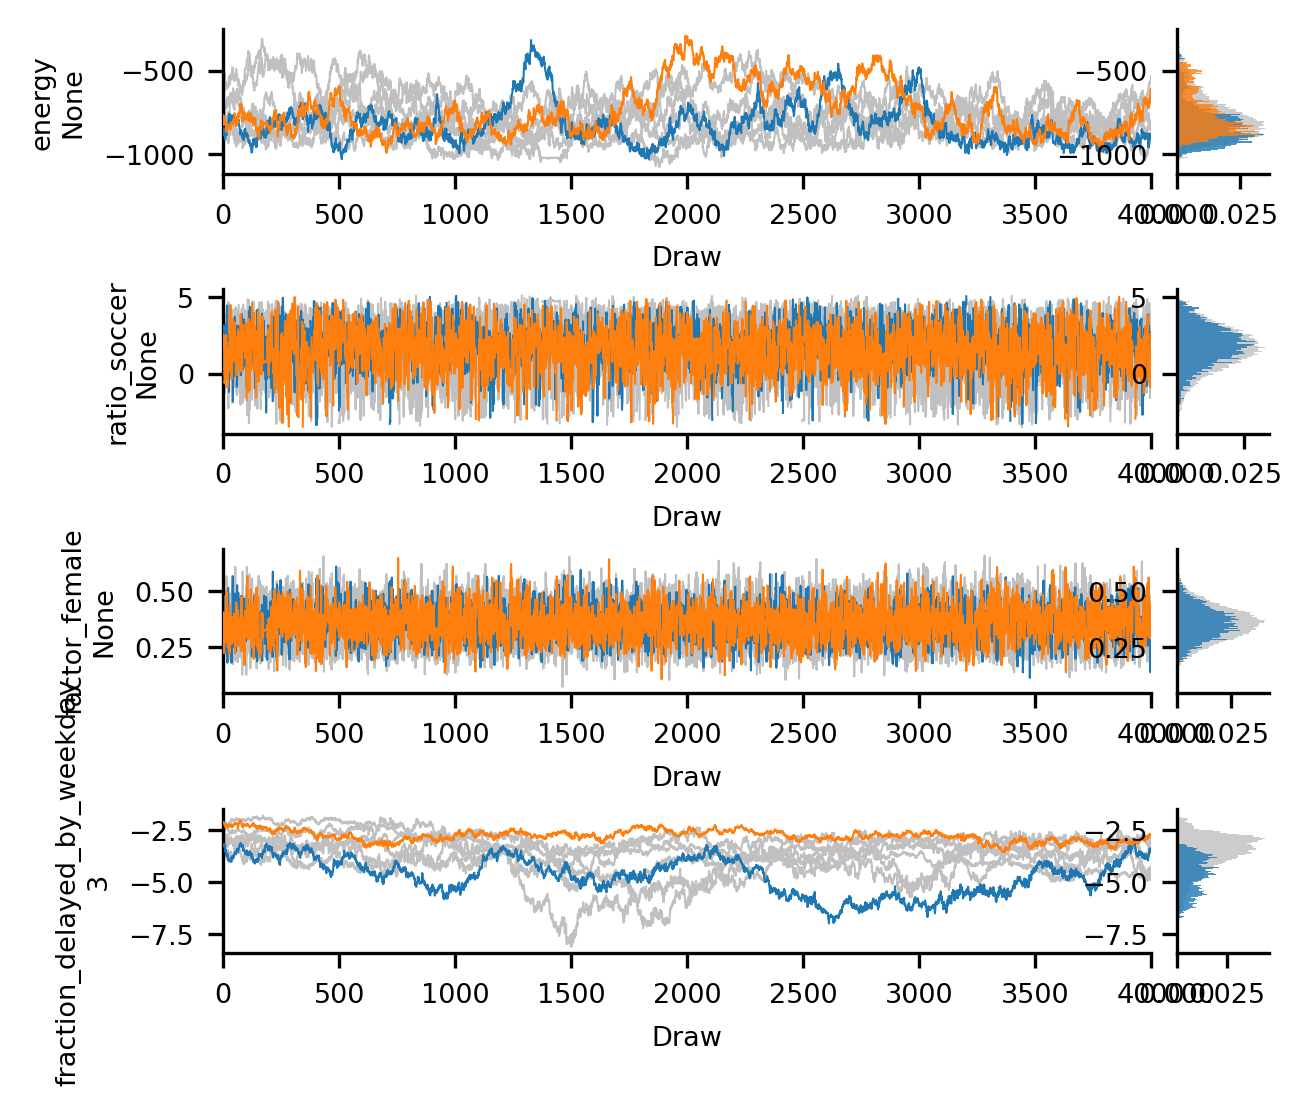

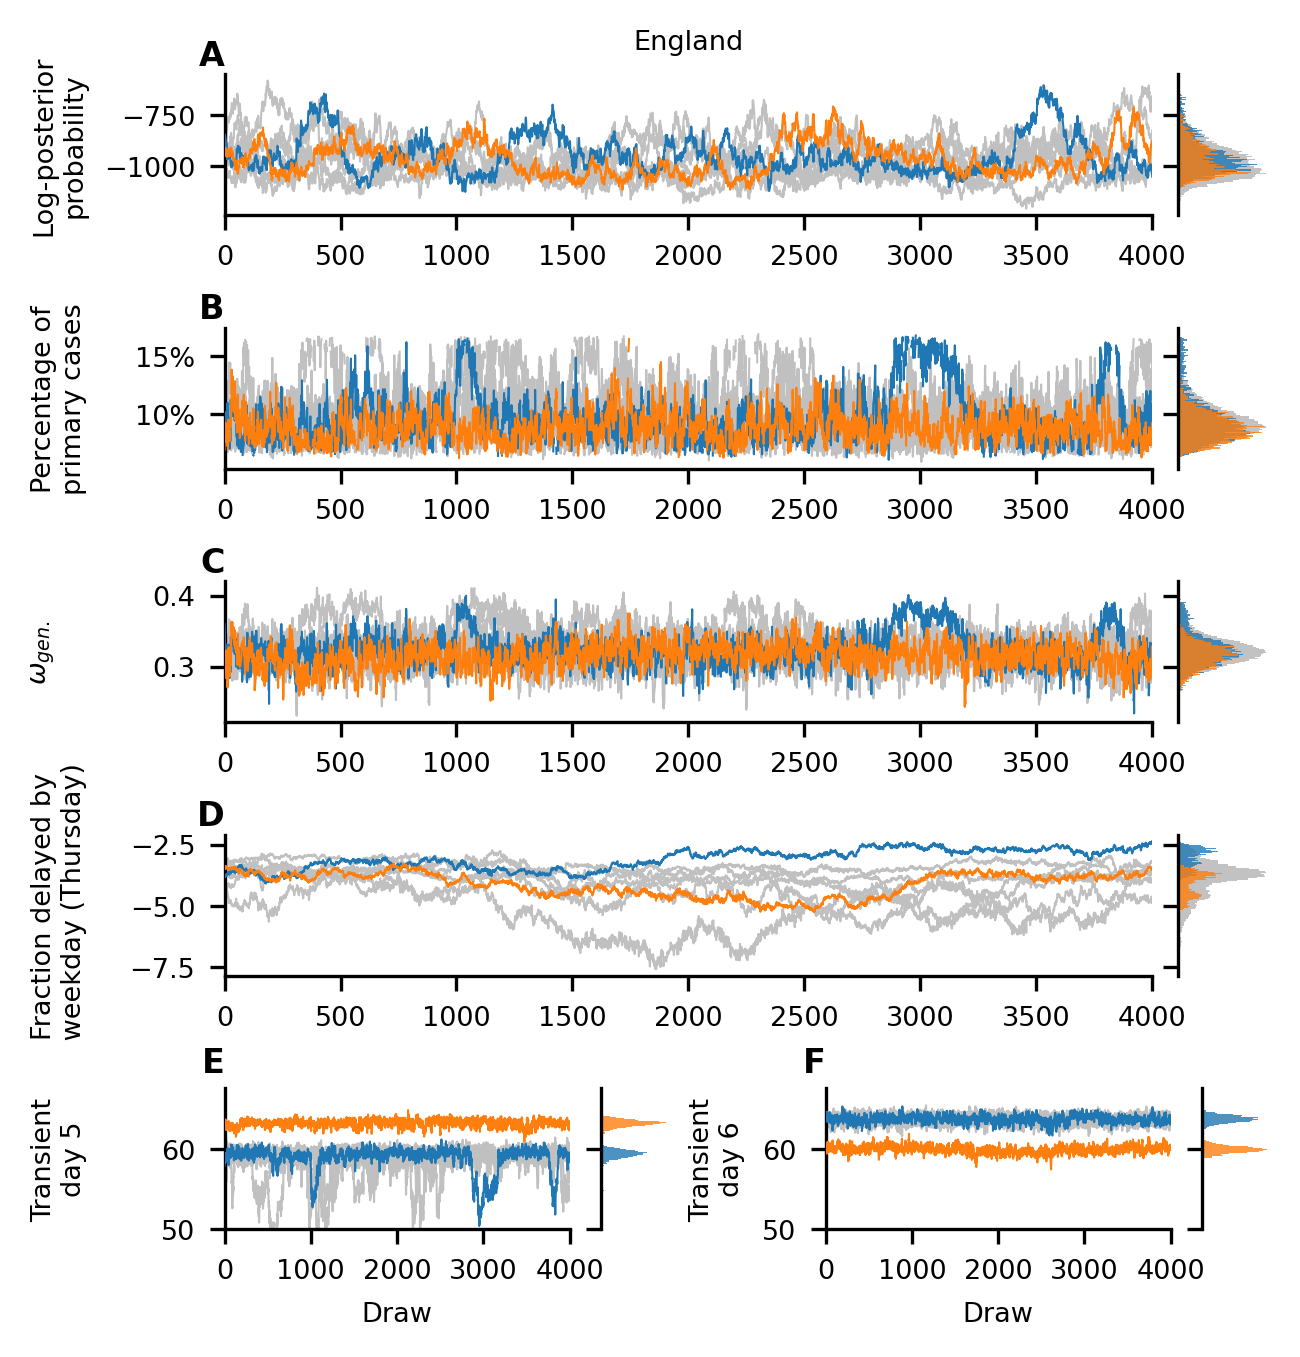

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


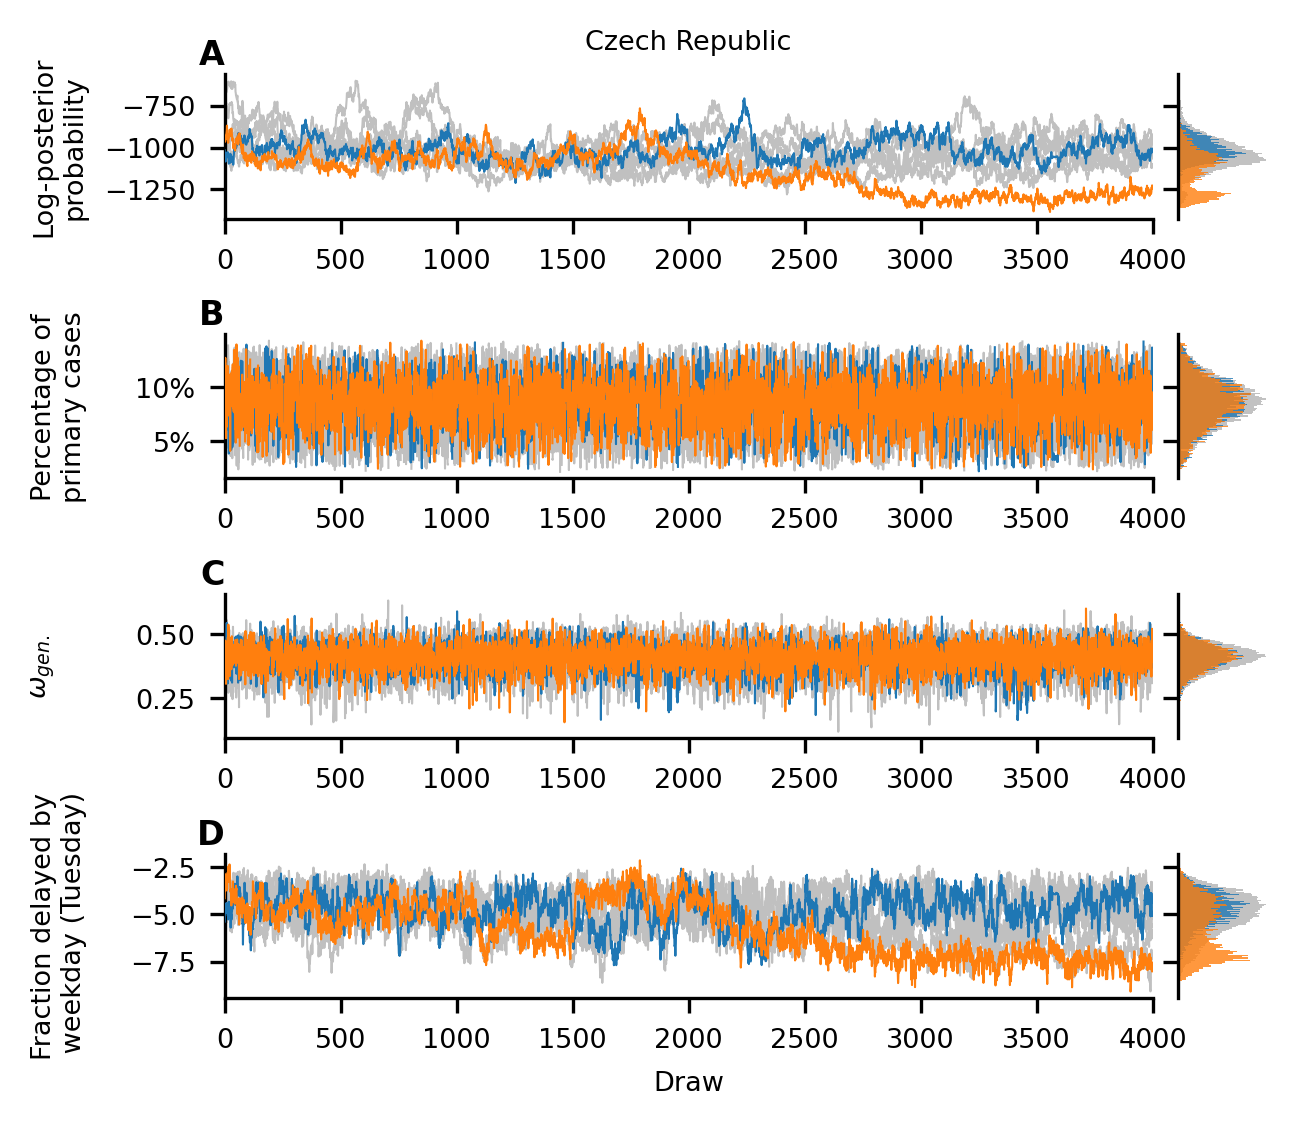

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


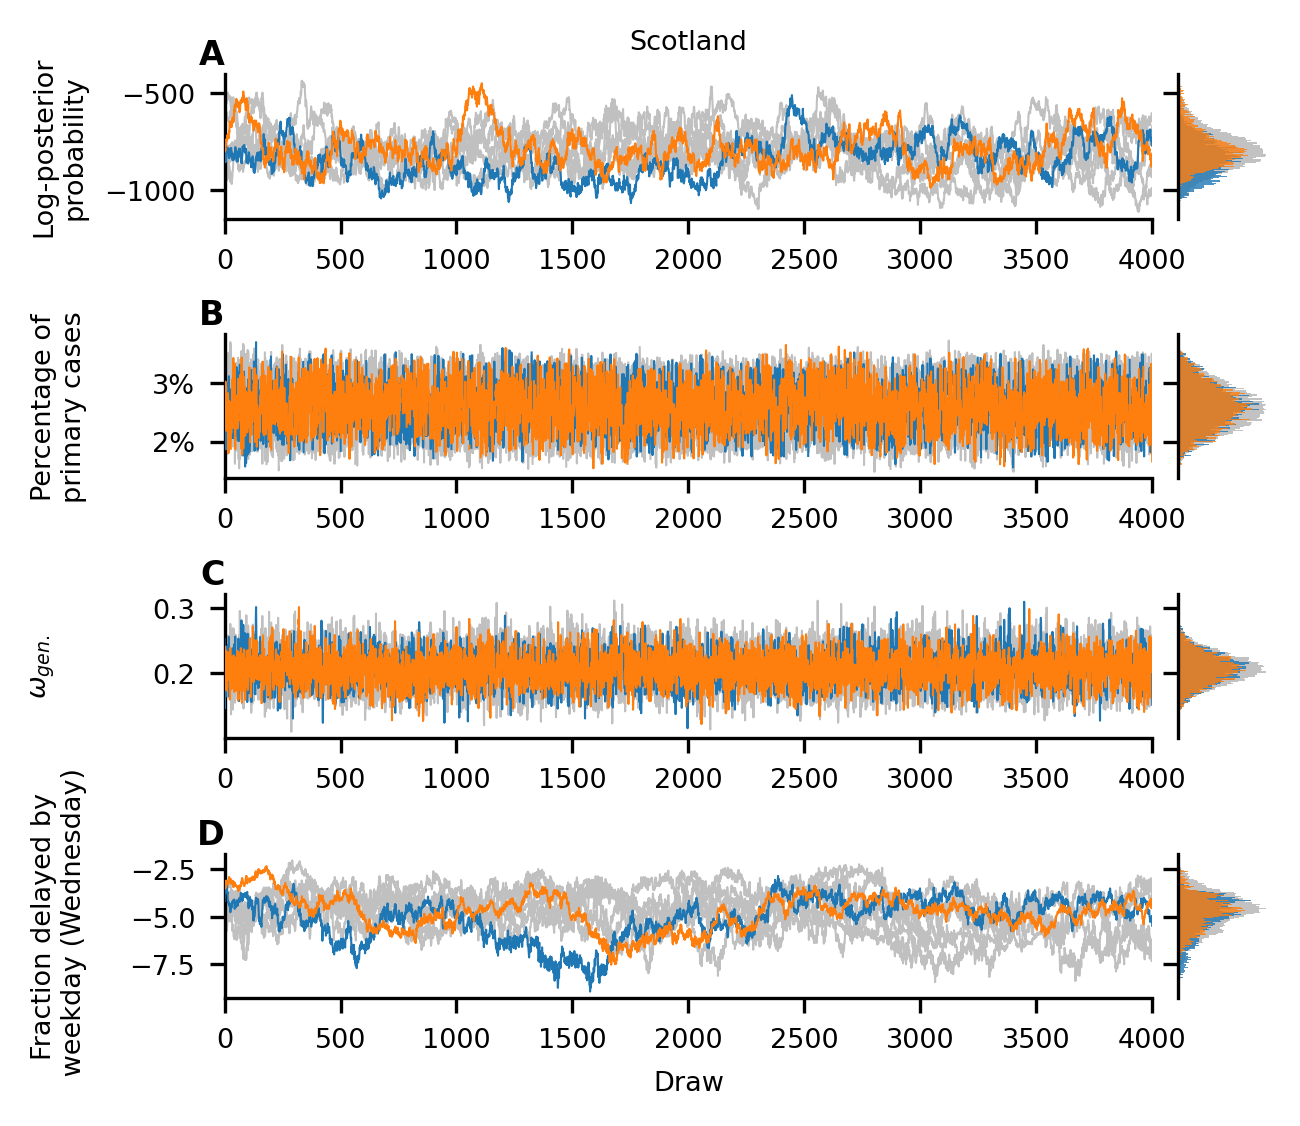

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


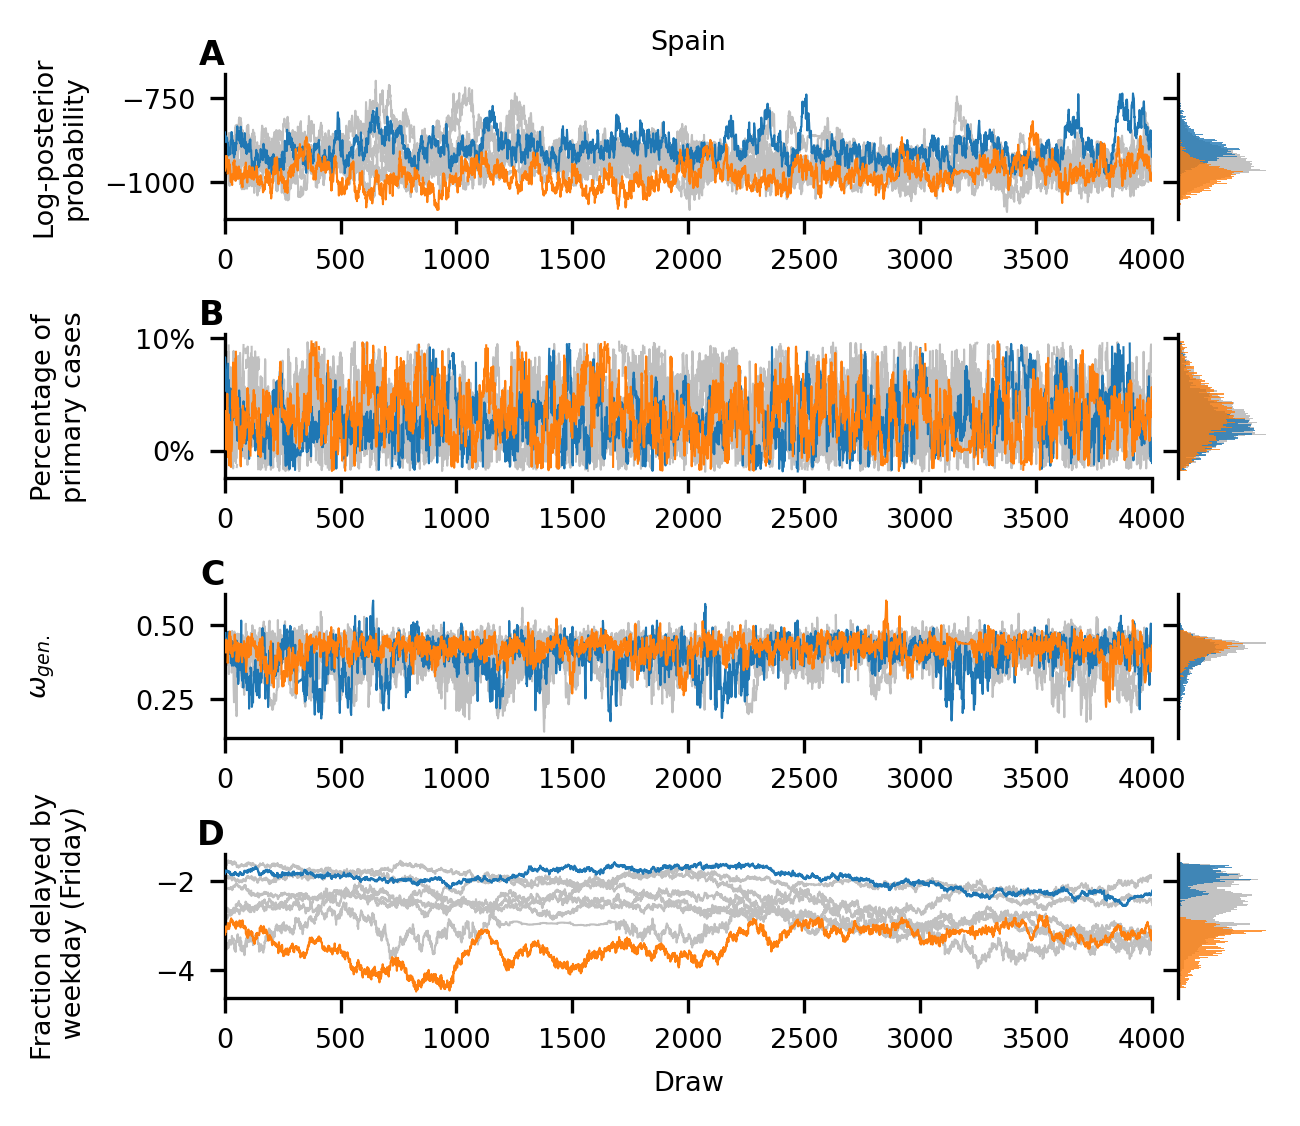

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


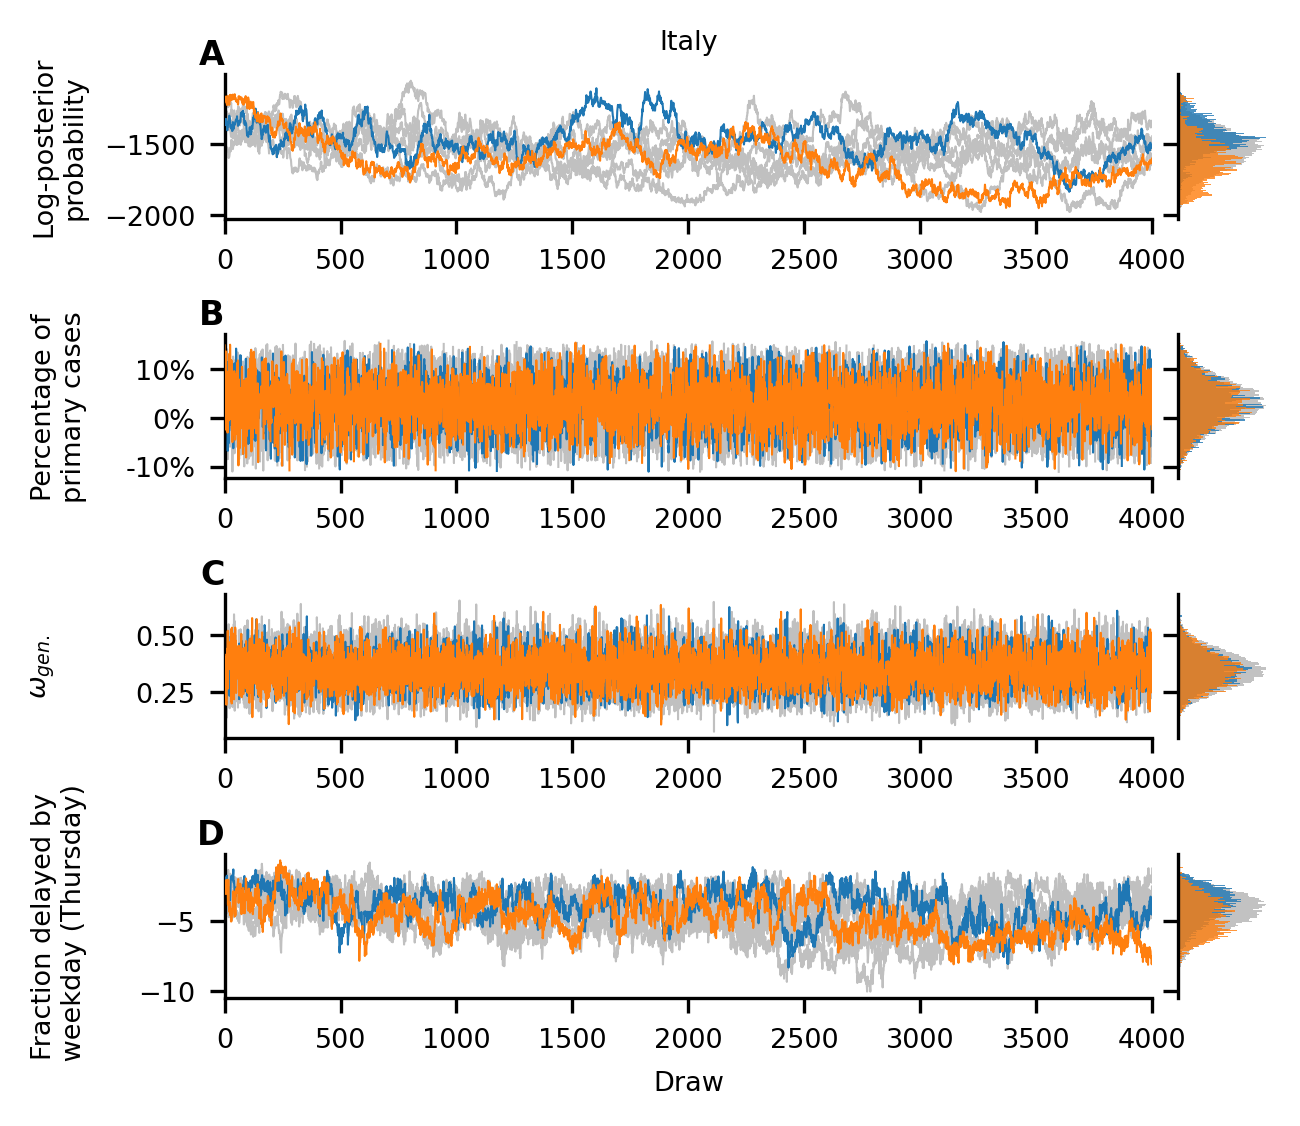

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


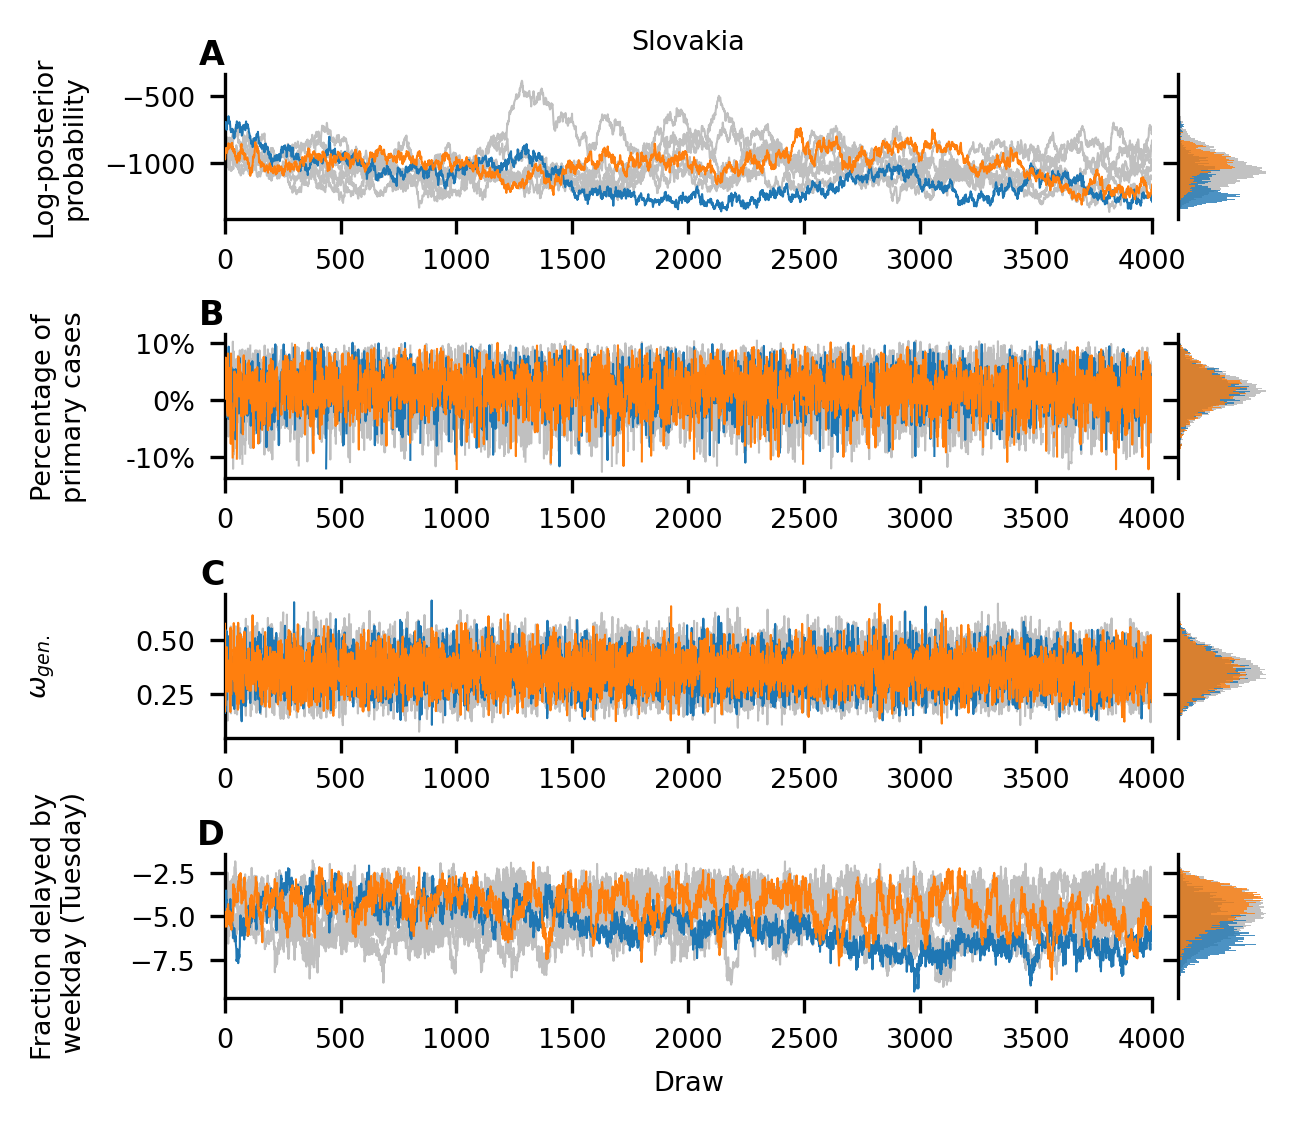

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


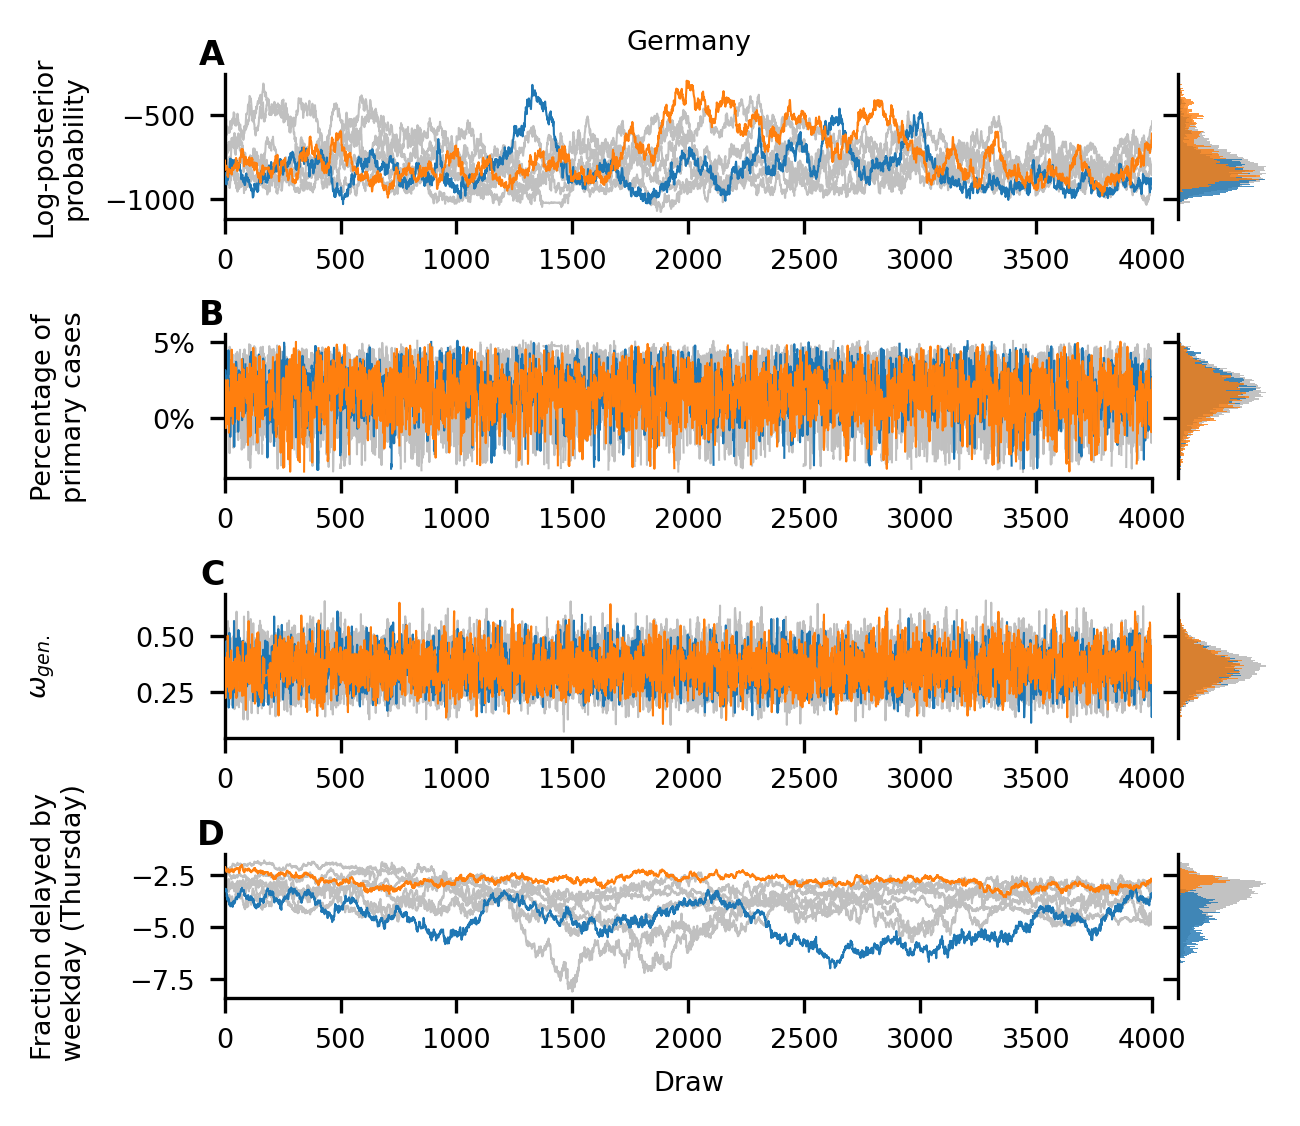

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


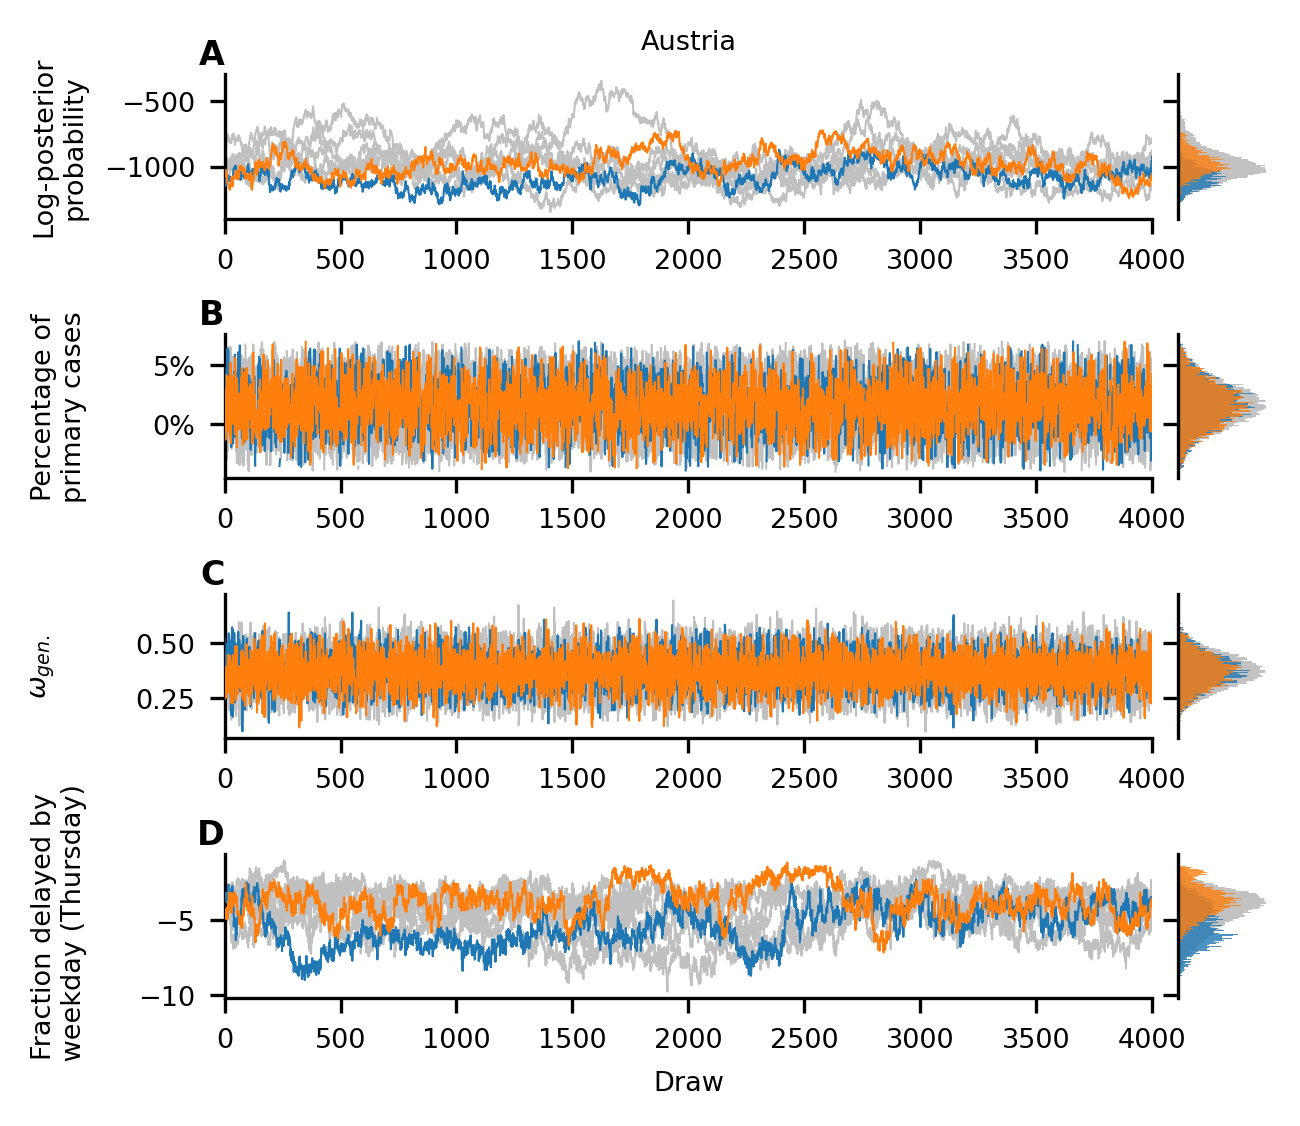

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


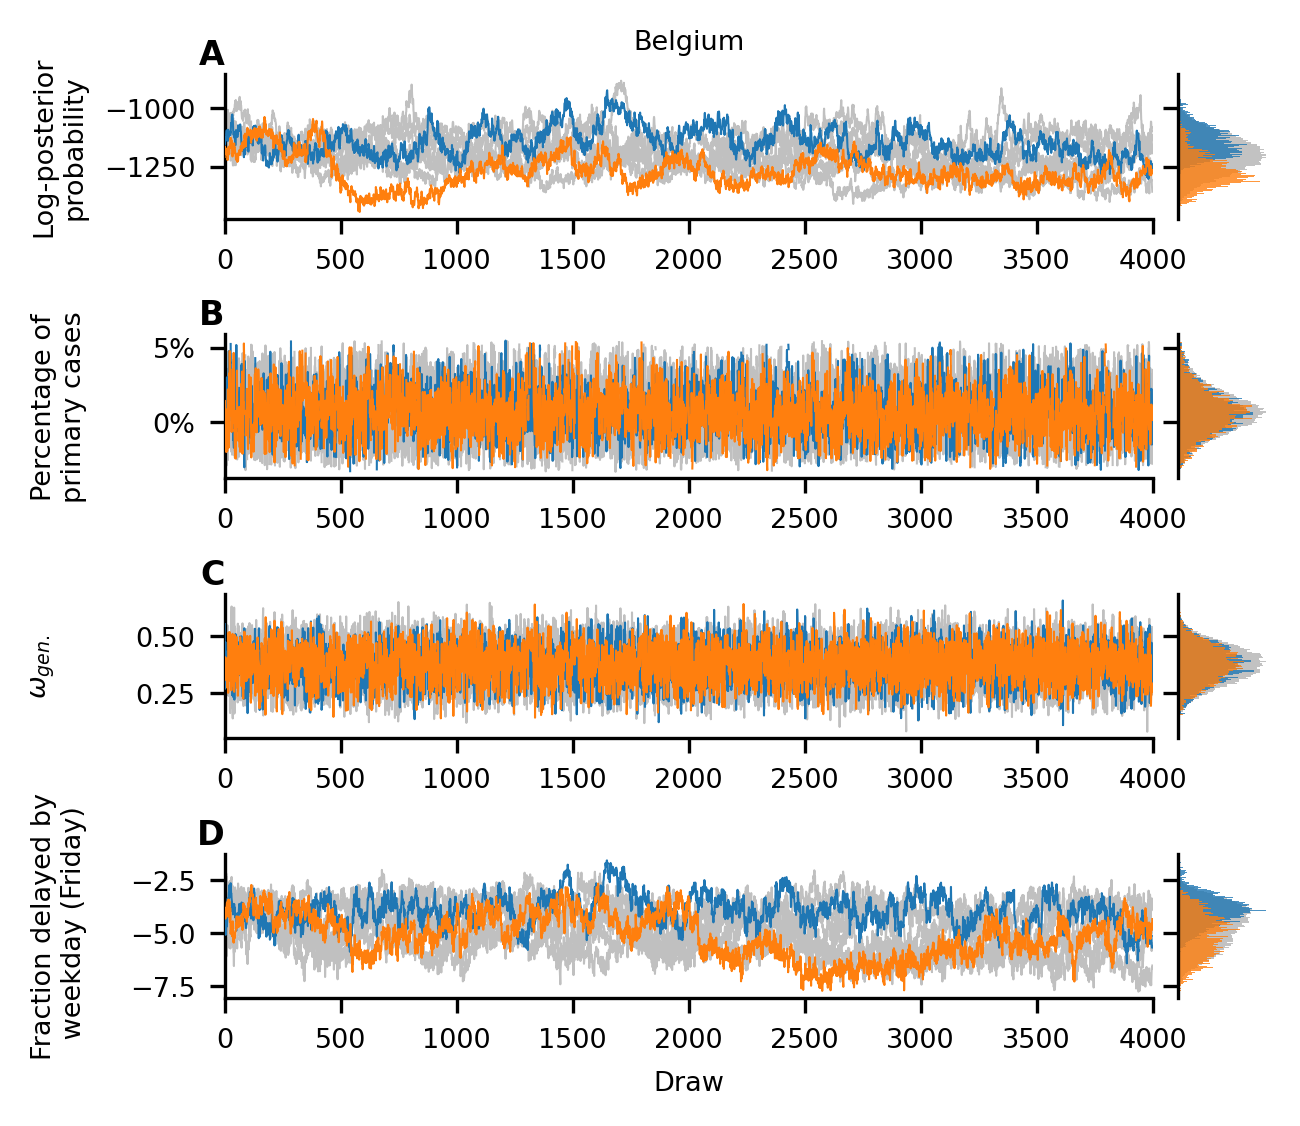

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


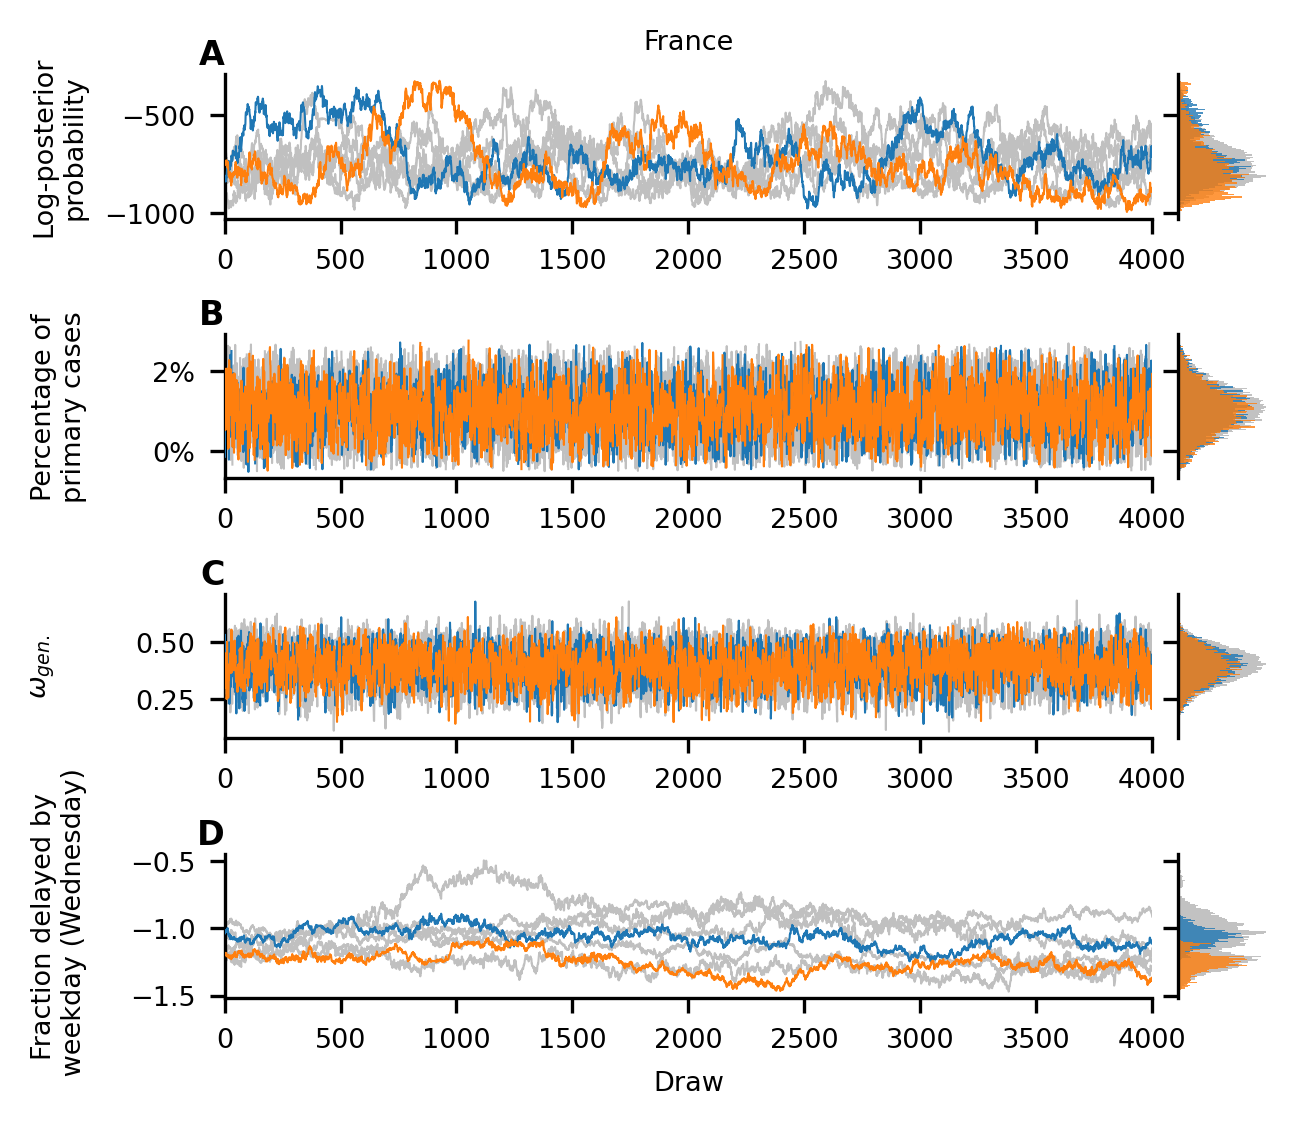

<ipython-input-211-b73559075014>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


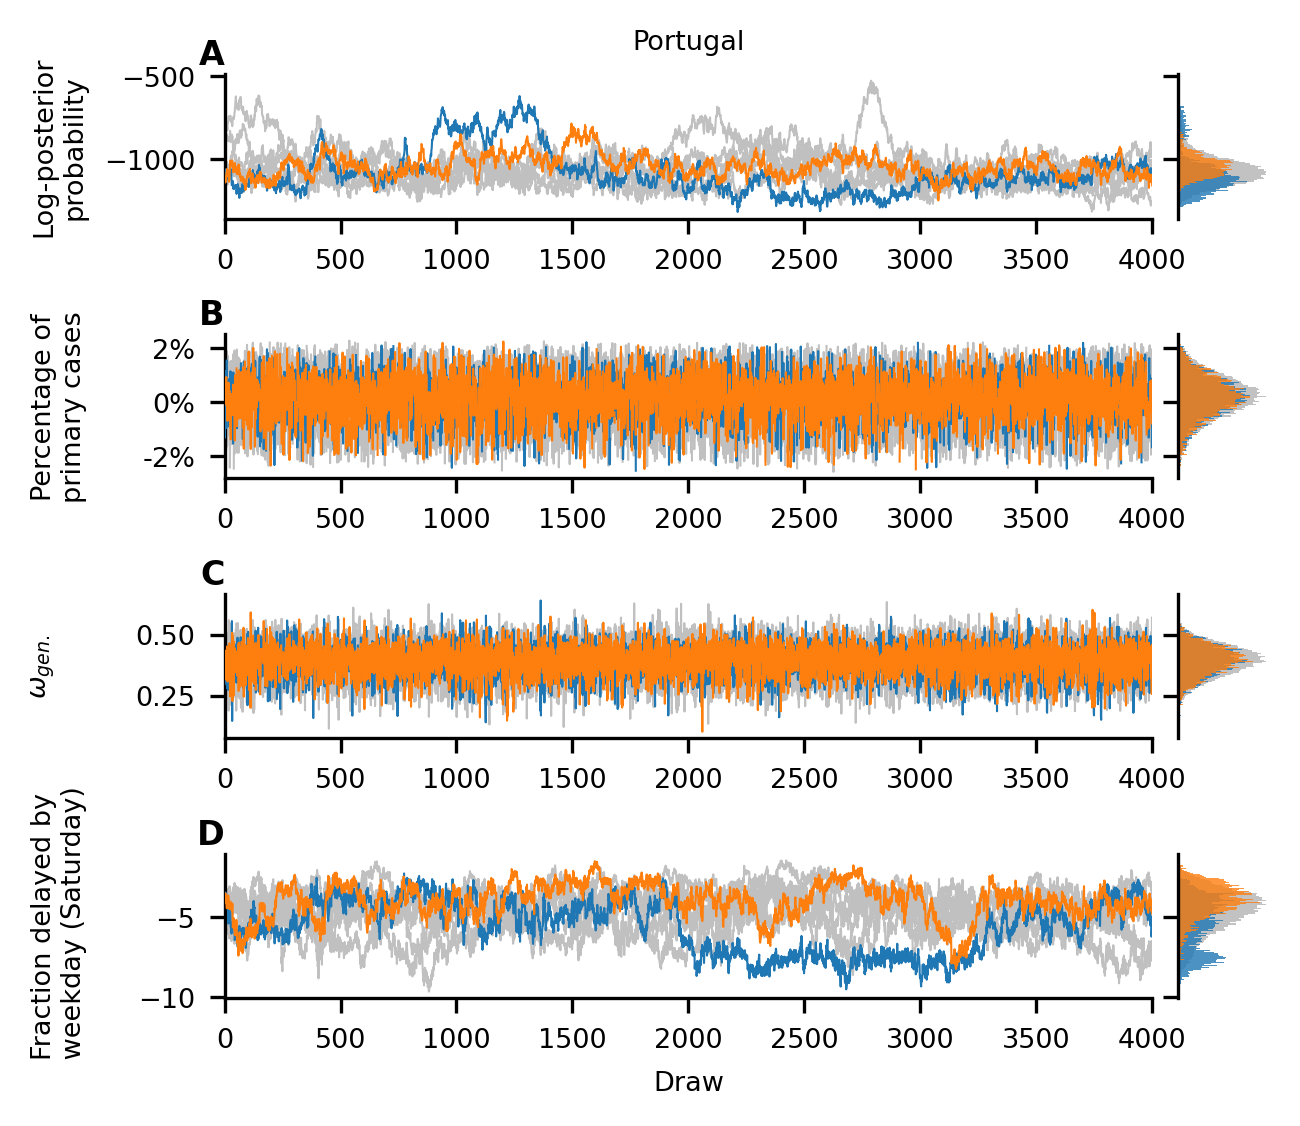

In [211]:
import matplotlib.gridspec as gridspec
import string
path = "../figures/SI/chain_mixing/"
alphabet_string = list(string.ascii_uppercase)

híghlight_dict = {
    "England": (3,4),
    "Czechia": (0,7),
    "Scotland": (0,6),
    "Spain": (0, 6),
    "Italy": (5, 7),
    "Slovakia":(1,2),
    "Germany":(0,3),
    "Austria":(1,6),
    "Belgium":(2,3),
    "France":(3,5),
    "Portugal":(2,7)
}


for i, country in enumerate(countries):
    highlight_chains = worst_chains[i]
    
    if country == "England":
        highlight_chains = [3,4]
        fig = plt.figure(figsize=(4.5,5))
        gs = gridspec.GridSpec(5, 2, hspace=0.8, wspace=0.35)
        
        # Create axes with inner grid
        axes = []
        axes_hist = []
        for j in range(4):
            inner_grid = gs[j,:3].subgridspec(1, 2, wspace=0.05, hspace=0, width_ratios=(10,1))
            axes.append(fig.add_subplot(inner_grid[0]))
            axes_hist.append(fig.add_subplot(inner_grid[1], sharey=axes[j]))
            
        #Special plot for england to show date hopping
        for j in range(2):
            inner_grid = gs[4, j].subgridspec(1, 2, wspace=0.15, hspace=0, width_ratios=(5,1))
            ax = fig.add_subplot(inner_grid[0])
            ax_hist =  fig.add_subplot(inner_grid[1],sharey=ax)
            var = f"transient_day_{5+j}"
            plot_trace(var, traces[i], ax, index=None, highlight_chains=highlight_chains)

            # Plot hist
            colors_chain = cmap = mpl.cm.get_cmap('tab10')
            kwargs = {
                "orientation":'horizontal',
                "bins":100,
                "alpha":0.8,
                "density":True
            }
            for t, c in enumerate(highlight_chains):
                ax_hist.hist(traces[i].posterior[var].values[c,...], color = colors_chain(t/10), **kwargs)
            axes_hist.append(ax_hist)

            ax.set_ylim(50,67.5)
            ax.set_ylabel(f"Transient\nday {5+j}")
            ax.text(
                0,
                1.3,
                alphabet_string[4+j],
                transform=ax.transAxes,
                fontsize=8,
                fontweight="bold",
                va="top",
                ha="right",
            )
            if j == 0:
                axes.append(ax)
    else:
        fig = plt.figure(figsize=(4.5,4))
        gs = gridspec.GridSpec(4, 1, hspace=0.8)
        
        # Create axes with inner grid
        axes = []
        axes_hist = []
        for j in range(4):
            inner_grid = gs[j,:3].subgridspec(1, 2, wspace=0.05, hspace=0, width_ratios=(10,1))
            axes.append(fig.add_subplot(inner_grid[0]))
            axes_hist.append(fig.add_subplot(inner_grid[1], sharey=axes[j]))

    # General plot for three selected
    plot_trace_selected(
        traces[i],
        models[i],
        dls[i],
        rhats[i],
        axes=axes,
        axes_hist=axes_hist,
        highlight_chains=highlight_chains
    )
    

    fig.align_ylabels(axes)
    if country == "Czechia":
        country = "Czech Republic"
    axes[0].set_title(country)
    fig.tight_layout()
    
    
    # Axis labels
    for s,i in enumerate([0,1,2,3]):
        letter = alphabet_string[s]
        axes[i].text(
            0,
            1.25,
            letter,
            transform=axes[i].transAxes,
            fontsize=8,
            fontweight="bold",
            va="top",
            ha="right",
        )

    # Axes hist markup
    for ax in axes_hist:
        ax.tick_params(axis="x", labelbottom=False)
        ax.tick_params(axis="y", labelleft=False)
        ax.spines.bottom.set_visible(False)
        ax.tick_params(bottom=False)


    #axes[0].legend()
    # Save figure
    fig.savefig(f"{path}chain_mixing_{country}.pdf", **save_kwargs)
    fig.savefig(f"{path}chain_mixing_{country}.png", **save_kwargs)
    plt.show()

In [ ]:
""" Old plotting for the worst parameters: (uncomment if needed)
for i, country in enumerate(countries):
    rhat_max = rhats[i].max()
    values = []
    for var in rhats[i].data_vars:
        values.append(rhat_max[var].values)

    # Get three biggest
    arg_three = np.argsort(values)[-3:]
    worst_vars = np.array(rhats[i].data_vars)[arg_three].tolist()
    
    
    # Add omega to worst vars for comparison
    worst_vars.append("factor_female")

    # Now we get the index of the max values
    fig, axes = plt.subplots(len(worst_vars),1,figsize=(7,len(worst_vars)*1.5))
    for var, ax in zip(worst_vars,axes):
        vals = rhats[i][var].to_numpy()
        if vals.ndim >= 1:
            index = np.unravel_index(np.argmax(vals),vals.shape)
        else:
            index = None
        plot_trace(var,traces[i],ax,index)

    fig.align_ylabels(axes)
    fig.suptitle(countries[i],fontsize="x-large")
    fig.tight_layout()
    plt.show()
"""

In [212]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 07 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

covid19_inference: 0.3.6
sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
arviz            : 0.11.4
matplotlib       : 3.5.1
pandas           : 1.2.4
numpy            : 1.20.3

Watermark: 2.3.1

